# Trait Weight Based Optimization

In [31]:
#imports required
import numpy as np
import numpy.random as rnd
import scipy
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from numpy import linalg as LA
import cvxpy as cp
import exp_setup
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from trait_weight_optimization.exp_setup import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
#installations

### Setup

We will modelling the robot team allocation to solve few independent challenges.

The species will be the 20 types of robots(divided into 4 groups).For each demonstration, each type of robot from the group will be randomly assigned to the expert.

There are 9 traits for each robot specie which are generic and mostly applicable to all of them. 

There are three task which are required to be completed with the allocation. 

In [33]:
# experiment settings
num_species = 4 #drone,rover,mini-rover,mini-drone
num_tasks = 3  #pick,search for target,move object
num_traits = 9 #speed,footprint,payload,reach,weight,sensing frequency,sensing range,color,battery capacity
traits = ["speed","footprint","payload","reach","weight","sensing frequency","sensing range","color","battery"]
num_demo = 1500

## Random Q vs Deterministic Q

### RANDOM Q

In [34]:
Q = []
for i in range(num_demo):
    Q.append(get_random_q())
Q = np.array(Q)
Q.shape

(1500, 4, 9)

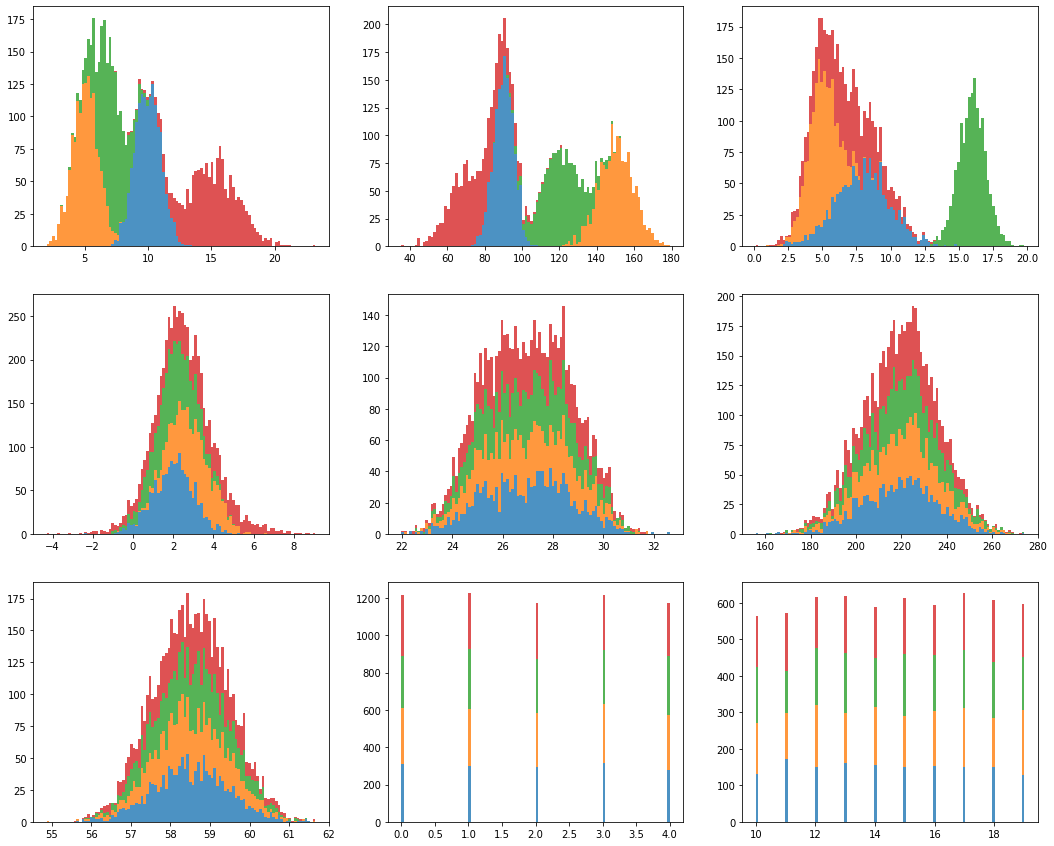

In [5]:
plt.rcParams["figure.figsize"] = (18,15)

#Species across all the 9 traits
figure, axs = plt.subplots(3,3)
for i, ax in enumerate(axs.flat):
    ax.hist(Q[:,:,i], bins=100, density=False,histtype='barstacked', alpha=0.8)

# #Species across all the 9 traits
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.hist(Q[:,:,i], bins=100, density=False,histtype='bar',alpha=0.6)

# #Species across all the 9 traits
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.hist(Q[:,:,i], bins=100, density=False,histtype='step',alpha=0.6)

# #Species across all the 9 traits
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.hist(Q[:,:,i], bins=100, density=False,histtype='stepfilled',alpha=0.6)

In [6]:
# #Visualizations
# plt.rcParams["figure.figsize"] = (18,15)

# #Species across all the 9 traits
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.plot(range(num_demo), Q[:,:,i],alpha=0.6)
#     ax.set_title(traits[i])

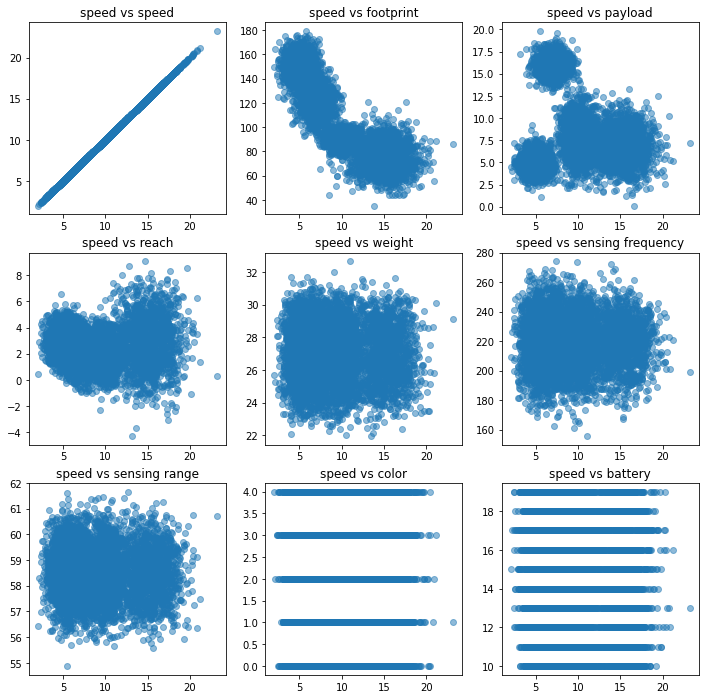

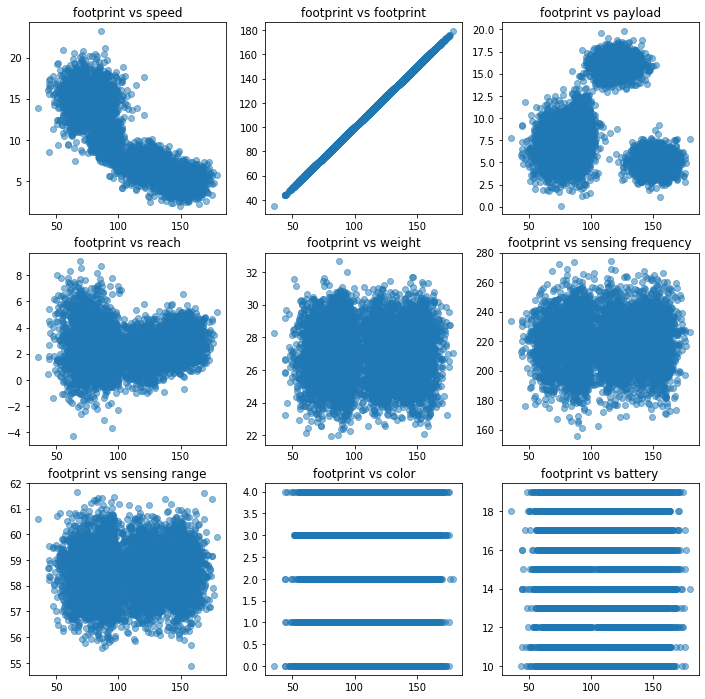

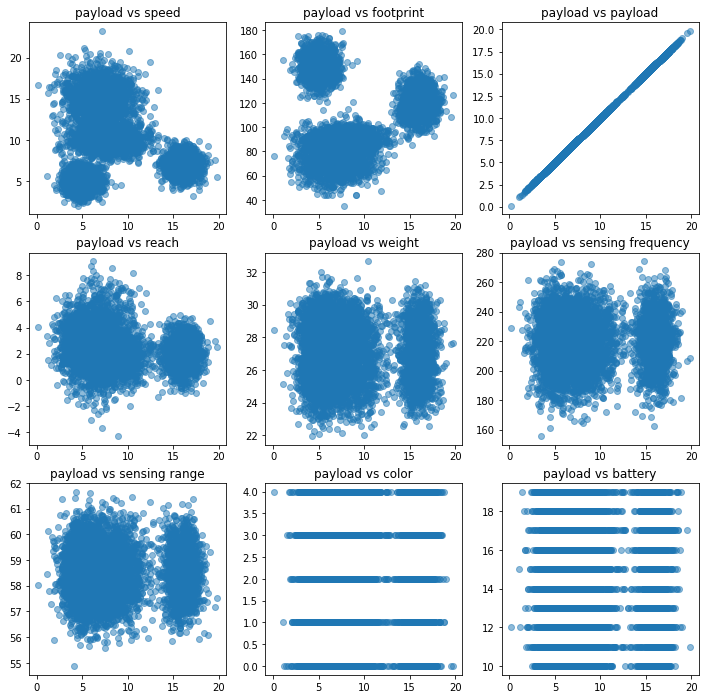

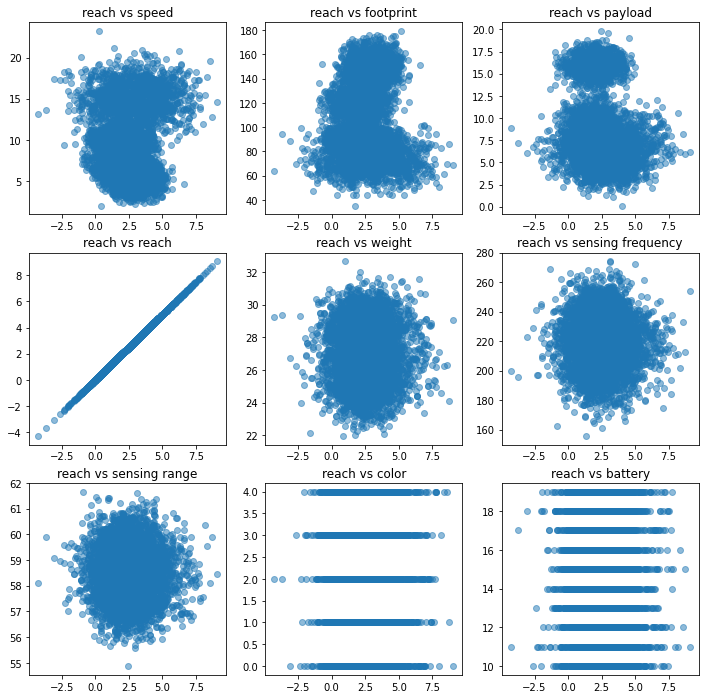

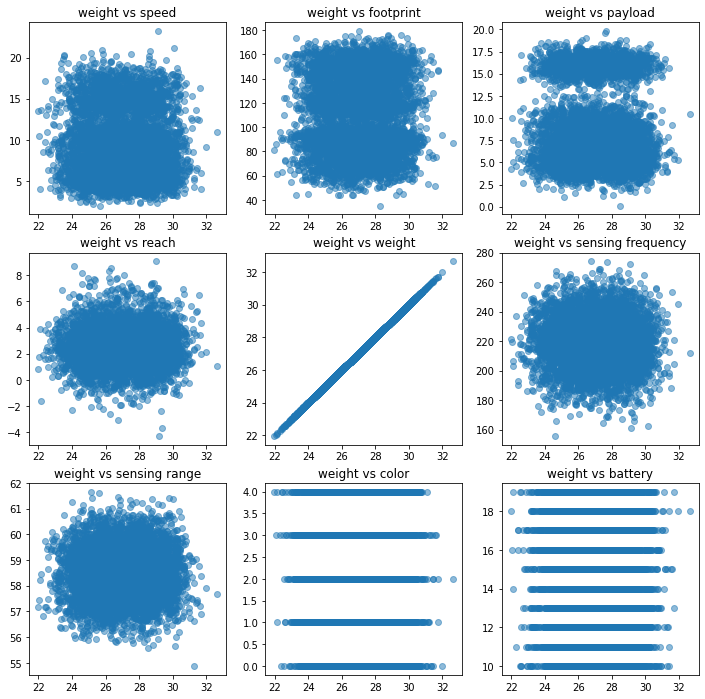

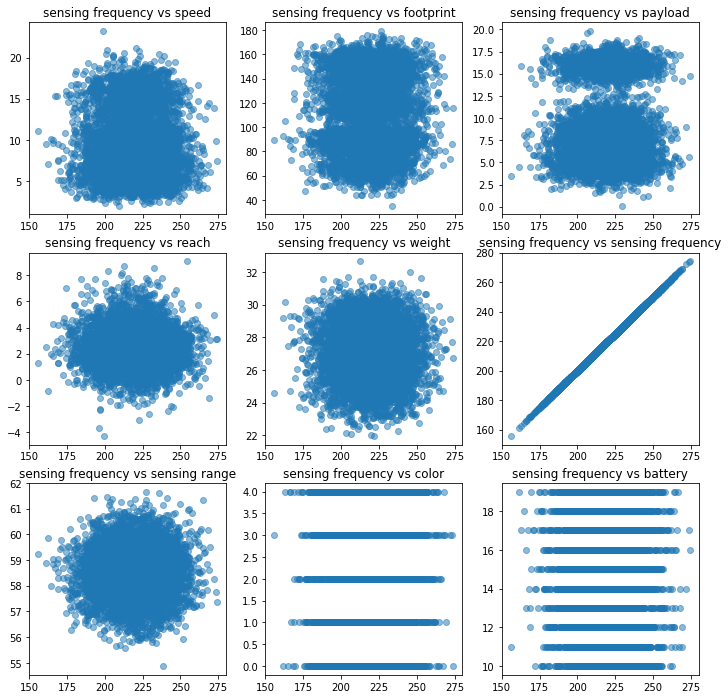

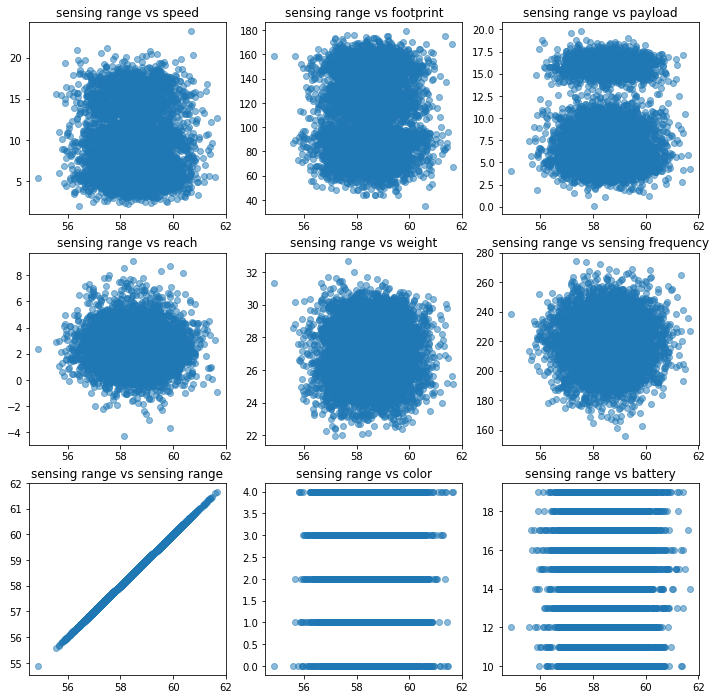

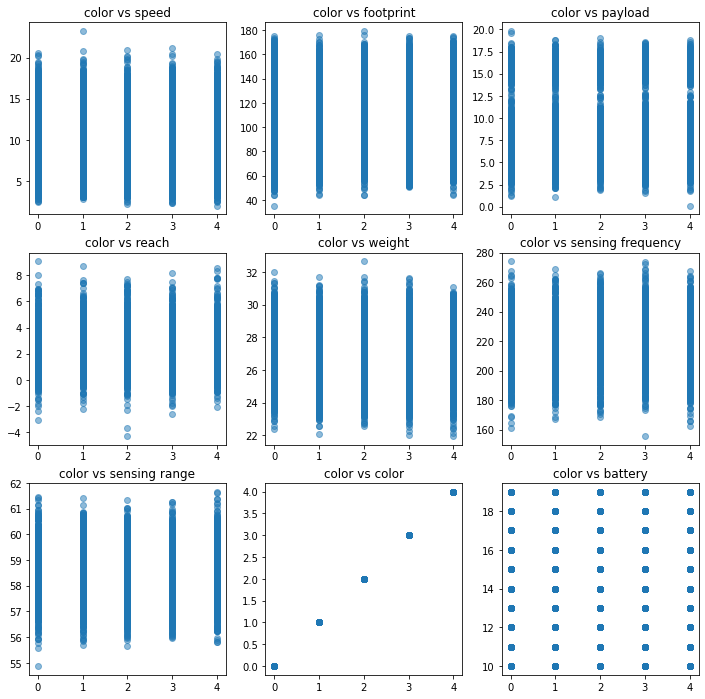

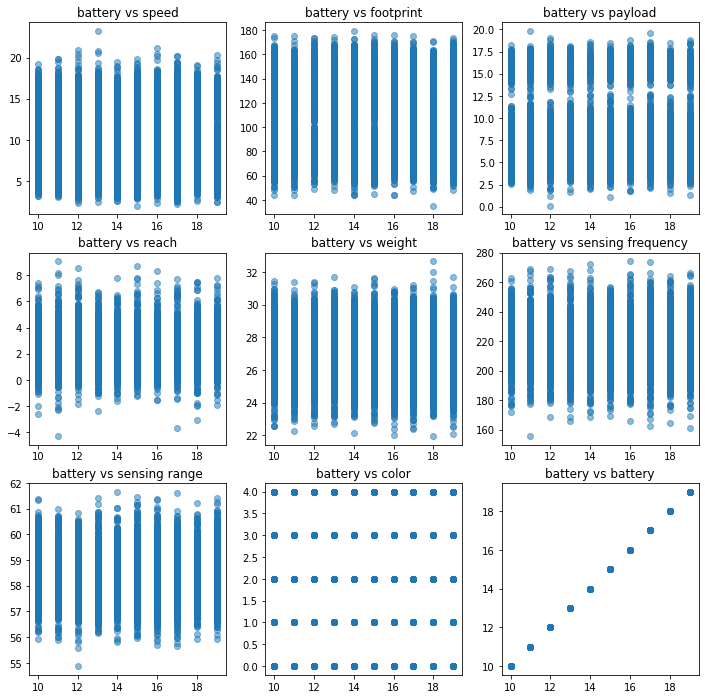

In [7]:
#Visualization Trait space

#Traits with respect to other traits can be mapped to visualize the traits spaces

#Visualizations
plt.rcParams["figure.figsize"] = (12,12)

#one trait to another
for t in range(num_traits):
    figure, axs = plt.subplots(3,3)
    for i, ax in enumerate(axs.flat):
        ax.scatter(Q[:,:,t], Q[:,:,i],alpha=0.5)
        ax.set_title(traits[t] + " vs "+ traits[i] )

(DETERMINISTIC Q)
FAILED IDEA

In [8]:
# Q_det = []
# for i in range(num_demo):
#     Q_det.append(get_deterministic_q())
# Q_det = np.array(Q_det)
# Q_det.shape

In [9]:
# plt.rcParams["figure.figsize"] = (18,15)

# #Species across all the 9 traits
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.plot(range(num_demo), Q_det[:,:,i],alpha=0.6)
#     ax.set_title(traits[i])

In [10]:
# plt.rcParams["figure.figsize"] = (12,12)

# #self maps
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.scatter(Q_det[:,:,i], Q_det[:,:,i],alpha=0.2)
#     ax.set_title(traits[i] + " vs "+ traits[i] )

# #one trait to another
# for t in range(num_traits):
#     figure, axs = plt.subplots(3,3)
#     for i, ax in enumerate(axs.flat):
#         ax.scatter(Q_det[:,:,t], Q_det[:,:,i],alpha=0.5)
#         ax.set_title(traits[t] + " vs "+ traits[i] )

## Y optimal formualtion

In [11]:
# n_agents_target = np.ones((num_tasks,num_species))*10
# n_agents_target
n_agents_target = np.ones(num_species)*10

In [12]:
#       #speed , footprint , payload , reach , weight , sensing frequency , sensing range,color,battery capacity
# y1 = [167.67539631 , 0 , 163.54336383 , 44.77054672 , 492.53035196 , 4000.24323205 , 1066.20140352 , 0 , 0]#pick
# y2 = [167.26818453 , 1969.70284216 , 0 , 0 , 488.97568317 , 3965.75731709 , 1059.38683684 , 0 , 262.56000000]#search for target
# y3 = [166.81653853 , 1969.43635325 , 161.43957528 , 0 , 488.32231989 , 0 , 1057.86312284 , 0 , 261.07266667]#move object
# y_star = np.array([y1 , y2 , y3]).astype(np.float)
# y_star


# y1 = [163.70974517, 0,  159.18052969,   42.25540358 , 474.86603947,  3915.18485378 ,1044.94916321 ,  0 ,  0]#pick
# y2 = [163.97756868, 1949.61484453 ,0, 0 , 480.46007361,3935.71503043 ,1047.99365735,   0.      ,    253.5       ]#search for target
# y3 = [ 164.43033649, 1957.56082303  ,161.87735218,   0,  486.34644624,0 ,1056.94635674  , 0,         257.5       ]#move object
# y_star = np.array([y1 , y2 , y3]).astype(np.float)

y_star = np.array([[ 122.53839519, 0.,  119.39044525,   32.15983648,
         360.87624558, 2920.25543052,  768.93055775,   0.        ,
         0.        ],
       [ 120.64147124, 1433.4094241 ,  0.,   0.,
         358.13547136, 2906.93229221,  766.11629311,   0.        ,
         190.        ],
       [ 122.31492305, 1441.74082593,  119.06910271,   0.,
         358.78852644, 0. ,  769.11520065,   0.        ,
         193.        ]])

In [13]:
def get_X():
    # X_test = np.random.randint(10, size=((num_tasks, num_traits)))

    X_test = np.zeros((num_tasks, num_species))
    task_restrict = range(num_tasks)
    for s in range(num_species):
        R = np.random.choice(task_restrict, size=n_agents_target[s].astype(int))
        for m in task_restrict:
            X_test[m, s] = np.sum(R == m)
        X_test = X_test.round()
    X_test = X_test.astype(np.int32)
    return X_test

In [14]:
X_test = []
for i in range(num_demo):
    x_i = get_X()
    X_test.append(x_i)
X_test = np.array(X_test)
Y_test = X_test@Q
print(Y_test.shape)
print(np.median(Y_test,axis=0))
print(np.mean(Y_test,axis=0))
print(np.std(Y_test,axis=0))
np.median(Y_test,axis=0)

(1500, 3, 9)
[[ 122.22887388 1455.52193354  117.87245545   31.77729491  359.67115922
  2916.47952613  770.12200243   26.          192.        ]
 [ 122.73568482 1435.52797358  119.38496148   32.21681803  355.56903572
  2910.46224897  769.11971359   26.          192.        ]
 [ 120.50161108 1449.90716781  116.32447799   32.04261493  355.86319177
  2903.63586226  767.18784674   25.          191.        ]]
[[ 123.89358266 1460.77123505  119.36653157   33.16116995  360.89620313
  2937.43235364  783.05591702   26.274       194.73333333]
 [ 123.47628443 1456.79670346  119.38081102   33.0592792   359.35062409
  2928.26465911  779.97942378   26.60933333  193.814     ]
 [ 123.19991786 1448.77233097  118.72581438   33.09900607  358.85893316
  2915.88891006  777.79348367   26.51        193.23933333]]
[[ 32.23300105 353.6014551   32.88723189  12.47047682  85.79325122
  687.28638191 180.44538002  11.71916908  49.29053549]
 [ 30.54150949 339.71765388  31.6312775   12.10537144  80.17947963
  656.0431

array([[ 122.22887388, 1455.52193354,  117.87245545,   31.77729491,
         359.67115922, 2916.47952613,  770.12200243,   26.        ,
         192.        ],
       [ 122.73568482, 1435.52797358,  119.38496148,   32.21681803,
         355.56903572, 2910.46224897,  769.11971359,   26.        ,
         192.        ],
       [ 120.50161108, 1449.90716781,  116.32447799,   32.04261493,
         355.86319177, 2903.63586226,  767.18784674,   25.        ,
         191.        ]])

In [15]:
#weight init
init_weight = np.eye(num_tasks)[np.random.choice(num_tasks, num_traits)].T 
init_weight

array([[0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 1., 1., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0.]])

### Experiment setup

In [16]:
X = []
for i in range(num_demo):
    X_sol = cp.Variable((num_tasks, num_species), integer=True)

        # minimize trait mismatch
    mismatch_mat = y_star - cp.matmul(X_sol, Q[i])  # trait mismatch matrix


    obj = cp.Minimize(cp.pnorm(mismatch_mat, 2))

    # ensure each agent is only assigned to one task
    constraints = [cp.matmul(X_sol.T, np.ones([num_tasks, 1])) <= np.array([n_agents_target]).T, X_sol >= 0]

    # solve for X_target
    opt_prob = cp.Problem(obj, constraints)
    opt_prob.solve(solver=cp.CPLEX)
    X_target = X_sol.value
    X.append(X_target)


X = np.array(X)

In [17]:
X.shape

(1500, 3, 4)

In [18]:
Y_actual = X@Q
Y_actual.shape

(1500, 3, 9)

In [59]:
norms = []

for i in range(num_demo):
    norms.append(LA.norm(y_star-Y_actual[i], 2))
norms = np.array(norms)
print(min(norms))
print(np.mean(norms))
print(max(norms))

bad_indx = []
for i in range(num_demo):
    if LA.norm(y_star-Y_actual[i],2) > np.mean(norms):
        bad_indx.append(i)

len(bad_indx)



1356.8413035638105
1598.4577795420694
1809.6162947415814


723

In [63]:
ind = np.argpartition(norms, -500)[-500:]
# norms[ind]
print(len(ind))

500


In [66]:
Q_t = np.delete(Q,ind,axis=0)
X_t = np.delete(X,ind,axis=0)
Y_t = X_t@Q_t

new_norms = []
new_demo_count = Q_t.shape[0]
for i in range(new_demo_count):
    new_norms.append(LA.norm(y_star-Y_t[i], 2))

print(new_norms[0], new_norms[371])
print(np.argmin(new_norms))
print(np.mean(new_norms))
print(max(new_norms))

1503.374556243311 1383.659847055163
371
1629.8008916704139
1937.3529291421373


In [54]:
new_Q = np.delete(Q,bad_indx,axis=0)
new_X = np.delete(X,bad_indx,axis=0)
new_Q.shape
new_X.shape

(777, 3, 4)

In [55]:
new_Y_actual = new_X@new_Q

In [56]:
norms = []
new_demo_count = new_Q.shape[0]
for i in range(new_demo_count):
    norms.append(LA.norm(y_star-new_Y_actual[i], 2))

print(min(norms))
print(np.mean(norms))
print(max(norms))

1383.659847055163
1626.2224968156838
1937.3529291421373


In [23]:
D = {'X': new_X, 'Q':new_Q, 'Y': new_Y_actual}
D.keys()

dict_keys(['X', 'Q', 'Y'])

In [24]:
np.mean(new_Y_actual, axis =0)

array([[ 161.92291873,  828.89742608,   81.94439266,   30.7240013 ,
         310.94920516, 2602.07788504,  675.6496021 ,   22.27155727,
         166.66151866],
       [ 111.11773807, 1455.37249268,  107.06249633,   30.17584387,
         353.22116475, 2883.06738457,  768.73895313,   26.34877735,
         190.23809523],
       [  20.18728969,  589.52585442,   22.74502535,   11.47035664,
         105.12436684,  823.22152629,  228.10075689,    7.75160875,
          57.54054053]])

In [25]:
np.median(new_Y_actual, axis =0)

array([[ 164.03085784,  828.54754557,   81.29444753,   29.82357407,
         311.79802292, 2601.78509495,  685.67851938,   22.        ,
         166.        ],
       [ 108.90372446, 1450.35400403,  104.7418889 ,   29.66341391,
         353.06549874, 2880.77199211,  763.2485107 ,   26.        ,
         191.        ],
       [  19.9869762 ,  602.02817476,   19.59886757,   11.36672164,
         106.02299711,  834.30521426,  233.38478704,    8.        ,
          56.        ]])

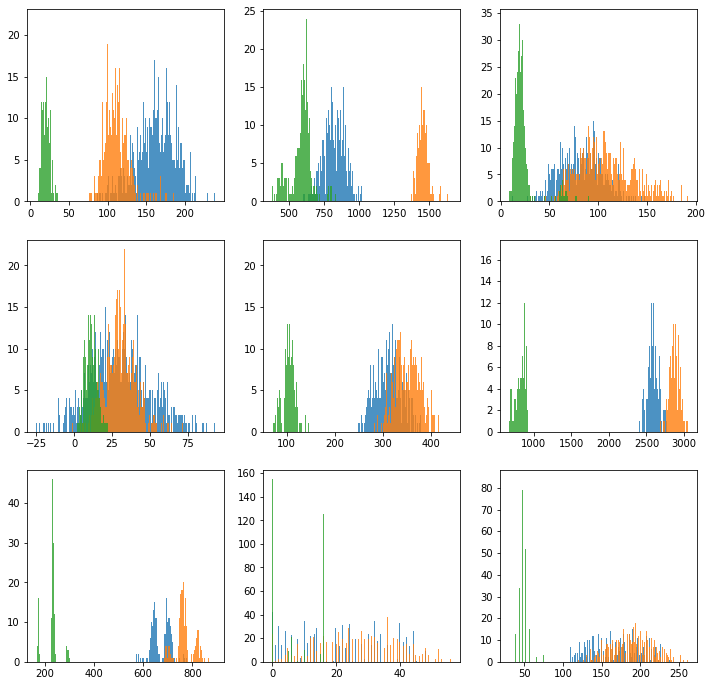

In [26]:
figure, axs = plt.subplots(3,3)
for i, ax in enumerate(axs.flat):
    ax.hist(new_Y_actual[:,0,i], bins=200, density=False,histtype='barstacked', alpha=0.8)
    ax.hist(new_Y_actual[:,1,i], bins=200, density=False,histtype='barstacked', alpha=0.8)
    ax.hist(new_Y_actual[:,2,i], bins=200, density=False,histtype='barstacked', alpha=0.8)


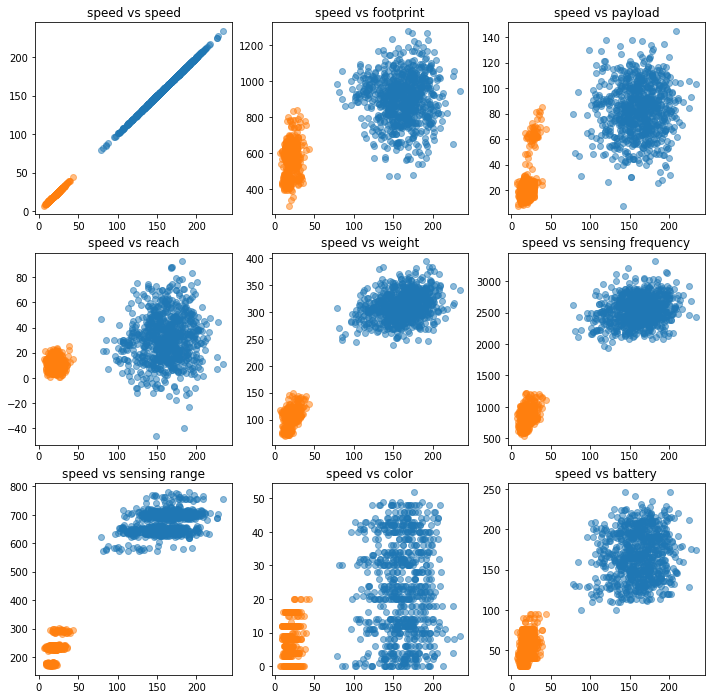

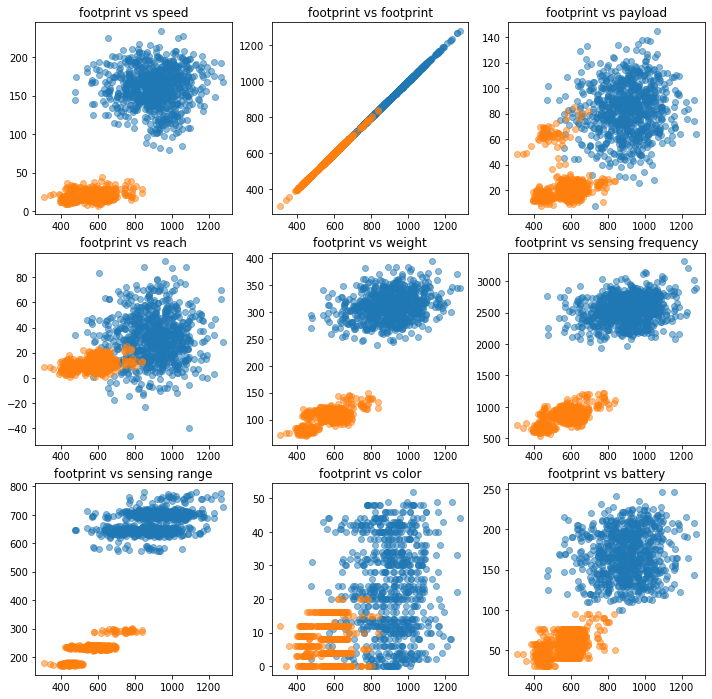

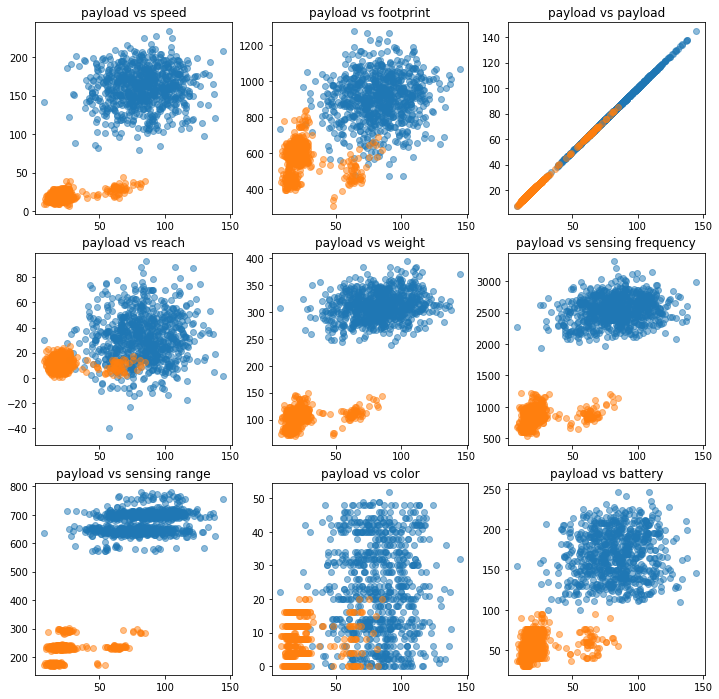

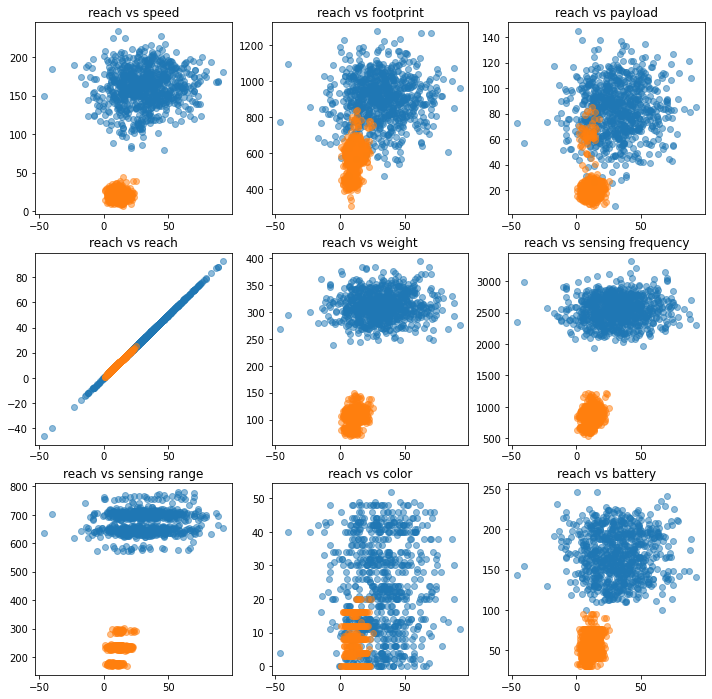

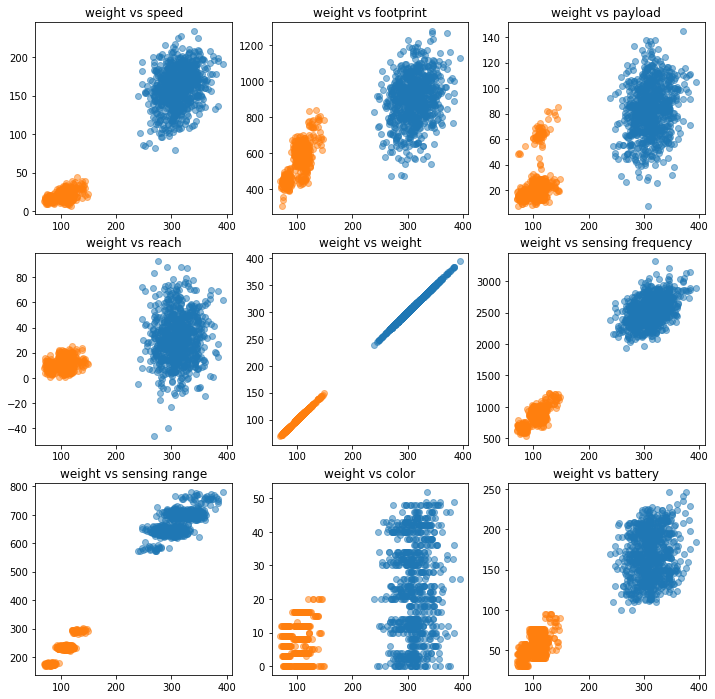

In [82]:
plt.rcParams["figure.figsize"] = (12,12)

#one trait to another
for t in range(num_traits):
    figure, axs = plt.subplots(3,3)
    for i, ax in enumerate(axs.flat):
        ax.scatter(new_Y_actual[:,0,t], new_Y_actual[:,0,i],alpha=0.5)
        ax.scatter(new_Y_actual[:,1,t], new_Y_actual[:,1,i],alpha=0.5)
        ax.scatter(new_Y_actual[:,2,t], new_Y_actual[:,2,i],alpha=0.5)

        ax.set_title(traits[t] + " vs "+ traits[i] )

In [27]:
Var_Y = np.var(new_Y_actual,axis=0)
Var_Y

array([[ 659.99870621, 7755.51316442,  447.43662138,  398.305238  ,
         673.0048425 , 5899.46904618, 1496.35144857,  206.82844453,
         960.56882798],
       [ 298.23366224, 1392.74674857,  794.36798646,  105.11188845,
         675.01583834, 3151.36022881, 1336.43609193,  158.18079966,
         719.53275738],
       [  25.2719292 , 5904.52818661,  166.58515973,   17.72320435,
         188.76153498, 4143.12194279,  676.66935137,   31.58695046,
         170.47486818]])

In [28]:
Var_Q = np.var(new_Q,axis=0)
Var_Q

array([[  0.97029805,  28.83487306,   3.76135269,   1.01426045,
          2.92506428, 265.33889523,   0.93275744,   1.9369916 ,
          7.76888968],
       [  0.94062778,  81.63679923,   0.98574734,   1.01088321,
          3.12185806, 277.00289828,   0.84983595,   2.00384941,
          8.29159772],
       [  1.06150263, 100.12973174,   0.92106848,   0.98757619,
          2.92717139, 285.50454895,   0.88226947,   1.97629731,
          8.07405309],
       [  4.19095355, 109.46722461,   4.22641489,   4.17692119,
          3.03350769, 208.60345303,   0.97395481,   1.96281444,
          8.45974601]])

In [29]:
print(new_Q[0],new_Q[1])

[[  8.94089051  94.87879684   6.54164376   1.85905183  28.89940615
  218.00794142  57.91296114   1.          19.        ]
 [  4.11677935 162.40585318   4.78521044   3.00374209  27.96053963
  198.10756261  58.19985725   3.          11.        ]
 [  7.65609766 113.60086491  16.52952973   2.07918556  26.34039683
  218.32664699  58.03842058   3.          15.        ]
 [ 14.70085383  62.9227463    7.5391432    3.17868264  27.13316606
  214.69565056  57.43238004   0.          16.        ]] [[  8.76355111  89.28317529   6.90778199   1.66395784  29.20394987
  222.09536168  58.12014988   2.          10.        ]
 [  4.48230396 163.33557057   5.18915376   3.10193437  30.29127176
  210.70161007  59.4137822    1.          17.        ]
 [  7.6010315  111.49131116  14.9748332    2.90614391  29.74293129
  218.3329404   58.54948653   2.          19.        ]
 [ 18.27570688  82.26145814   8.61543582   3.39599609  27.04316242
  219.98082625  59.35538323   1.          17.        ]]


In [30]:
pca = PCA()
pca.fit(new_Y_actual[:,1,:])
# print(pca.get_covariance().shape)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

print(pca.n_samples_)
print(pca.n_features_)
print(pca.n_components_)
print(pca.singular_values_)

[3194.21426236 2629.8279495   898.97013672  623.28759692  513.85599661
  311.68638375  216.0843014   155.08653159   99.09524762]
[0.36961053 0.30430398 0.10402209 0.07212217 0.05945956 0.03606601
 0.02500366 0.01794545 0.01146656]
777
9
9
[1574.3920311  1428.54698516  835.22501524  695.46471888  631.46833125
  491.80141703  409.48921584  346.91086537  277.30472797]


## IMPLEMENTATION

In [70]:
Q_j = get_random_q()
y_hat = np.mean(new_Y_actual, axis =0)

In [72]:
X_sol = cp.Variable((num_tasks, num_species), integer=True)

# minimize trait mismatch
mismatch_mat = y_hat - cp.matmul(X_sol, Q_j)  # trait mismatch matrix
obj = cp.Minimize(cp.pnorm(mismatch_mat, 2))

# ensure each agent is only assigned to one task
constraints = [cp.matmul(X_sol.T, np.ones([num_tasks, 1])) <= np.array([n_agents_target]).T, X_sol >= 0]

# solve for X_target
opt_prob = cp.Problem(obj, constraints)
opt_prob.solve(solver=cp.CPLEX)
X_target = X_sol.value
print(X_target)

[[2. 1. 3. 5.]
 [3. 5. 3. 2.]
 [0. 3. 1. 0.]]


In [79]:
print(LA.norm(y_star-X_target@Q_j,2))
print(LA.norm(y_star-y_hat,2))
print(LA.norm(y_hat-X_target@Q_j,2))

1622.7784593778888
1608.676671365117
72.99165914869191
